In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [2]:
torch.cuda.set_device(2)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 384

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='vit_base_patch32_384',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('vit_base_patch32_384',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.241019,0.173672,0.516667,0.508632,0.982051,0.670166,0.664596,01:41


Better model found at epoch 0 with f1_score value: 0.6701662292213473.


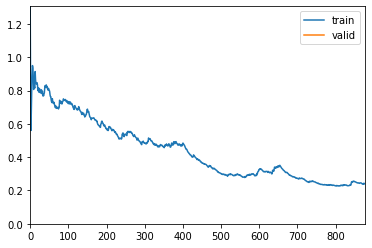

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.173663,0.169270,0.601282,0.570410,0.820513,0.672976,0.685138,01:43
1,0.168025,0.170775,0.612821,0.576923,0.846154,0.686071,0.686999,01:43
2,0.166062,0.161803,0.626923,0.591160,0.823077,0.688103,0.698360,01:43
3,0.158106,0.168796,0.646154,0.609615,0.812821,0.696703,0.721325,01:45
4,0.161161,0.172944,0.642308,0.647215,0.625641,0.636245,0.711479,01:46
5,0.166620,0.225885,0.605128,0.574818,0.807692,0.671642,0.690999,01:46
6,0.159814,0.247193,0.639744,0.657971,0.582051,0.617687,0.692518,01:46
7,0.164950,0.172535,0.639744,0.664653,0.564103,0.610264,0.698107,01:46


Better model found at epoch 0 with f1_score value: 0.6729758149316508.


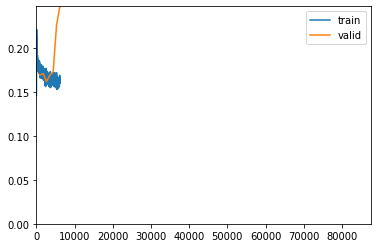

Better model found at epoch 1 with f1_score value: 0.6860706860706861.
Better model found at epoch 2 with f1_score value: 0.6881028938906751.
Better model found at epoch 3 with f1_score value: 0.6967032967032967.
No improvement since epoch 2: early stopping


In [11]:
learn.fine_tune(100,base_lr=3e-4)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.7073172912557527.


(#6) [0.1802583783864975,0.6389743685722351,0.5995591476855253,0.8369230769230769,0.6986301369863013,0.7073172912557527]

# 224

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='deit_base_patch16_224',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [10]:
learn = Learner(dls,timm.create_model('deit_base_patch16_224',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /home/jonathan/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


SuggestedLRs(valley=0.00019054606673307717)

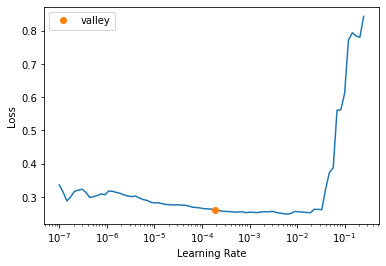

In [11]:
learn.lr_find()

In [ ]:
learn.fine_tune(100,base_lr=6e-3)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time


In [ ]:
dfTest = pd.read_csv('../testSample.csv')

In [ ]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [ ]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()